# LSTM Method

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("drive/MyDrive/nlp_data/raw/cleaned_data.csv")

In [ ]:
data["genre"] = data["genre"].str.split(',')

In [ ]:
train_df, test_df = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 24930
Number of rows in test set: 6233


In [ ]:
terms = tf.ragged.constant(train_df["genre"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Biography', 'Animation', 'Horror', 'Romance', 'Thriller', 'Mystery', 'Fantasy', 'Sci-Fi', 'Family', 'Documentary', 'History', 'Short', 'Music', 'Sport', 'War', 'Musical', 'Western', 'Film-Noir', 'Reality-TV', 'Game-Show', 'Talk-Show', 'News', 'Adult']


In [ ]:
batch_size = 128
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genre"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["preprocessed_plot"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [ ]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [ ]:
vocabulary = set()
train_df["preprocessed_plot"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

30725


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
encoder = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy", f1_m, precision_m, recall_m]
)

In [ ]:
history = model.fit(train_dataset, epochs=20)

Epoch 1/20
195/195 [==============================] - 16s 17ms/step - loss: 0.2937 - categorical_accuracy: 0.4066 - f1_m: 0.0132 - precision_m: 0.2291 - recall_m: 0.0135
Epoch 2/20
195/195 [==============================] - 3s 17ms/step - loss: 0.2307 - categorical_accuracy: 0.4477 - f1_m: 0.1416 - precision_m: 0.4827 - recall_m: 0.0862
Epoch 3/20
195/195 [==============================] - 3s 17ms/step - loss: 0.2084 - categorical_accuracy: 0.4575 - f1_m: 0.3217 - precision_m: 0.6280 - recall_m: 0.2177
Epoch 4/20
195/195 [==============================] - 3s 17ms/step - loss: 0.1834 - categorical_accuracy: 0.4759 - f1_m: 0.4648 - precision_m: 0.6841 - recall_m: 0.3542
Epoch 5/20
195/195 [==============================] - 3s 17ms/step - loss: 0.1599 - categorical_accuracy: 0.4666 - f1_m: 0.5651 - precision_m: 0.7344 - recall_m: 0.4601
Epoch 6/20
195/195 [==============================] - 3s 17ms/step - loss: 0.1426 - categorical_accuracy: 0.4786 - f1_m: 0.6241 - precision_m: 0.7728 - re

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          1966400   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 29)                1885      
                                                                 
Total params: 2,042,589
Trainable params: 2,042,589
Non-

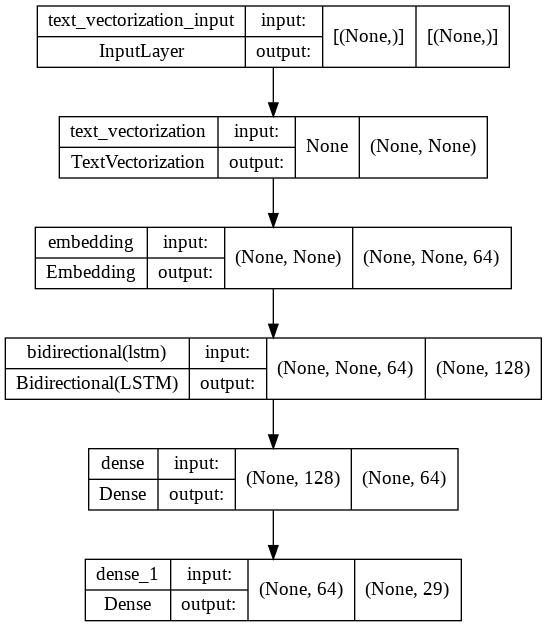

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

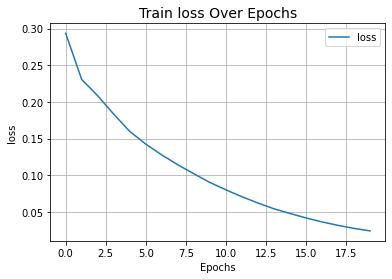

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.title("Train {} Over Epochs".format('loss'), fontsize=14)
plt.legend()
plt.grid()
plt.show()

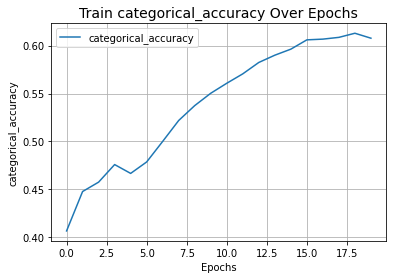

In [ ]:
plt.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
plt.xlabel("Epochs")
plt.ylabel('categorical_accuracy')
plt.title("Train {} Over Epochs".format('categorical_accuracy'), fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
loss_metric, categorical_acc, f1_metric, precision_metric, recall_metric = model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")
print(f"f1 metric on the test set: {f1_metric}.")
print(f"precision on the test set: {precision_metric}.")
print(f"recall on the test set: {recall_metric}.")

49/49 [==============================] - 3s 8ms/step - loss: 0.5711 - categorical_accuracy: 0.3485 - f1_m: 0.4622 - precision_m: 0.4809 - recall_m: 0.4451
Categorical accuracy on the test set: 34.85%.
f1 metric on the test set: 0.46216341853141785.
precision on the test set: 0.48089316487312317.
recall on the test set: 0.4451489746570587.
